<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

# Desafío 04

## Integrantes

- Acevedo Zain, Gaspar (acevedo.zain.gaspar@gmail.com)

## Consignas

- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

## Información General

### ***Descripción***

Este notebook corresponde a la resolución del trabajo práctico número $4$ de la materia `Procesamiento del Lenguaje Natural` de la `Carrera Especialización en Inteligencia Artificial` de la FIUBA.

El mismo utiliza como base código provisto por la materia, más precisamente la notebook [clase_6/jupyter_notebooks/tensorflow/6c - traductor.ipynb](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb).

### ***Propósito***

El propósito de la misma es construir un modelo traductor de inglés a español **seq2seq** utilizando una arquitectura **encoder-decoder**. Para ello, se utiliza como base los datos disponibles de **Tatoeba Project** (más info [aquí](https://www.manythings.org/anki/)).

### ***Organización del notebook***

Este notebook presenta las siguientes secciones:

1. **Imports**: sección donde se realizan los distintos imports bibliotecas de python que serán utilizadas.
1. **Constantes**: se definen una serie de constantes comúnes a todos los experimentos realizados.
1. **Carga de datos**: en esta sección se cargan los datos de traducciones de **Tatoeba Project**, más precisamente, las traducciones del inglés a español.
1. **Funciones útiles**: en esta sección se refactoriza el código provisto por la materia (notebook [6c - traductor.ipynb](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb)) a fin de que pueda ser reutilizado fácilmente en distintos experimentos.
1.**Definición de embeddings**:
    1. Se descargan los embeddings de `gloveembedding` a fin de utilizarlos en la arquitectura propuesta, más precisamente, en el `Encoder`.
    1. Se crean una serie de clases útiles para facilitar el uso de embeddings.
    1. NOTE: el código está basado en la notebook [6c - traductor.ipynb](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb).
1. **Experimentos**: se definen una serie de experimentos, los cuales tienen las siguientes sub-secciones
    1. **Constantes del experimento**: aquí se definen una serie de constantes únicas de cada experimento.
    1. **Preprocesamiento**: se generan los tokens de las capas de entrada y salida (encoder y decoder, respectivamente) de cada experimento.
    1. **Preparar los embeddings**: se generan los embeddings de la capa de entrada (encoder) del experimento en cuestión.
    1. **Entrenar el modelo**: se entrena el modelo generado para el experimento.
    1. **Gráficos**: se realizan gráficos de **Loss** y **Accuracy** por **epoch** relacionados al entrenamiento.
    1. **Inferencia**: a partir de los modelos entrenados en el experimento, se realizan inferencias y se detallan conclusiones.
1. **Conclusiones finales**: como indica el nombre, se detallan las conclusiones finales del trabajo.

### ***Ambiente de trabajo***

El presente notebook fue ejecutado en **Google Colab**, más precisamente, en una instancia con las siguientes características:

- *Runtyme*: Python 3.
- *Acelerador de Hardware*: `T4 GPU`.
- *Memoria RAM*: $12.7$ GB.
- *GPU RAM*: $15.0$ GB.
- *Disco*: $112.6$ GB.

### ***Limitaciones del ambiente de trabajo***

Si bien en el ambiente de trabajo se cuenta con GPU, la memoria ram disponible ($12.7$ GB) no resulta suficiente para la carga completa del dataset de traducciones.

Dicho dataset consta de $118964$ rows, lo cual requiere demasiada RAM para cargarlo (y utilizarlo al entrenar modelos).

Por este motivo, se decide limitar la cantidad de filas a leer en $6000$ (definido en la constante **MAX_NUM_SENTENCES** en la sección de **Constantes**).

Se realizaron pruebas con números mayores (por ejemplo: $7000$, $8000$), pero al entrenar los modelos se producía errores en el runtime de Google Colab por falta de RAM.

## Imports

In [50]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, Input, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.utils import plot_model, to_categorical

import logging
import os
from pathlib import Path
from io import StringIO
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

## Constantes

Se definen constantes comúnes a todos los experimentos.

La cantidad de secuencias máximas a leer del dataset de traducciones de *Inglés a Español* es de $6000$ por limitaciones de la memoria RAM disponible en Colab (más info en la sección **Información General - Limitaciones del ambiente de trabajo** de esta notebook).

In [51]:
SPANISH_TEXT_FILE = "./spa-eng/spa.txt"
MAX_NUM_SENTENCES = 6000
RANDOM_SEED = 40
VALIDATION_SPLIT = 0.2

Se definen una serie de *inputs* que serán utilizados por los modelos de los distintos experimentos para realizar inferencias.

Los tres primeros inputs corresponden a textos que se encuentran en el Dataset.
Las últimas dos corresponden a textos por fuera del dataset, a fin de saber como el modelo traduce texto *nuevo*.

In [52]:
INPUT_TESTS = [
    "My mother says hi.",
    "Mary wants to buy a dress.",
    "My mother takes a nap every afternoon.",
    "My father is looking for you.",
    "You are the laziest student",
]

## Carga de datos

De la misma manera que en la notebook utilizada como base, se utilizan los datos disponibles del **Tatoeba Project** de traducciones de texto en diferentes idiomas.

Se construirá un modelo traductor de inglés a español **seq2seq** utilizando **encoder-decoder**.

[LINK](https://www.manythings.org/anki/)

In [53]:
import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [54]:
text_file = SPANISH_TEXT_FILE
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([RANDOM_SEED])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [55]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

## Funciones útiles

In [56]:
def input_output_tokenizer(input_sentences: list, output_sentences: list,
                           output_sentences_inputs: list,
                           max_vocab_size: int = 8000,
                           filters: str = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'):
  """
  Función que crea los tokenizadores del idioma inglés (input) y del idioma
  español (output).
  Devuelve los tokenizadores, secuencias de enters y diccionarios de palabra
  a índice de cada idioma (inglés y español).
  Se utiliza como base el código provisto por la materia (sección "2 - Preprocesamiento").
  SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
  """
  # tokenizador de inglés
  input_tokenizer = Tokenizer(num_words=max_vocab_size)
  input_tokenizer.fit_on_texts(input_sentences)
  input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

  word2idx_inputs = input_tokenizer.word_index

  # tokenizador de español
  output_tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters)
  output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
  output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
  output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

  word2idx_outputs = output_tokenizer.word_index

  # Se suma 1 para incluir el token de palabra desconocida
  num_words_output = min(len(word2idx_outputs) + 1, max_vocab_size)

  return input_tokenizer, input_integer_seq, word2idx_inputs, output_tokenizer, output_integer_seq, output_input_integer_seq, word2idx_outputs, num_words_output

In [57]:
def generar_encoder_decoder_sequences(input_integer_seq: list,
                                      output_integer_seq: list,
                                      output_input_integer_seq: list,
                                      num_words_output: int,
                                      padding: str = 'post',
                                      max_input_len: int = 16,
                                      max_out_len: int = 18):
  """
  Genera las secuencias de input del encoder y decoder, como así también el
  output del decoder, utilizando Padding.
  Se utiliza como base el código provisto por la materia (sección "2 - Preprocesamiento").
  SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
  """
  encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)

  decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding=padding)

  decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding=padding)
  decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

  return encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, decoder_targets

In [58]:
def crear_matriz_embeddings_para_inputs(model_embeddings, word2idx_inputs, max_vocab_size: int):
  """
  Crea la matriz de embeddings para los inputs (inglés).
  Se utiliza como base el código provisto por la materia (sección "3 - Preparar los embeddings").
  SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
  """
  embed_dim = model_embeddings.N_FEATURES
  words_not_found = []

  nb_words = min(max_vocab_size, len(word2idx_inputs))
  embedding_matrix = np.zeros((nb_words, embed_dim))

  for word, i in word2idx_inputs.items():
      if i >= nb_words:
          continue
      embedding_vector = model_embeddings.get_words_embeddings(word)[0]
      if (embedding_vector is not None) and len(embedding_vector) > 0:

          embedding_matrix[i] = embedding_vector
      else:
          words_not_found.append(word)
  return embedding_matrix, words_not_found, nb_words, embed_dim

In [59]:
def generar_modelos(n_units: int, max_input_len: int, max_out_len: int,
                    num_words_output: int, embedding_matrix, nb_words, embed_dim,
                    activation: str ='softmax',
                    loss:str ='categorical_crossentropy',
                    optimizer:str = "Adam", metrics:list = ['accuracy']):
  """
  Genera los modelos encoder-decoder, encoder (por separado), y decoder (por separado).
  Se utiliza como base el código provisto por la materia (sección "4 - Entrenar el modelo").
  SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
  """
  # define training encoder
  encoder_inputs = Input(shape=(max_input_len,))

  encoder_embedding_layer = Embedding(
            input_dim=nb_words,
            output_dim=embed_dim,
            input_length=max_input_len,
            weights=[embedding_matrix],
            trainable=False)

  encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

  encoder = LSTM(n_units, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
  encoder_states = [state_h, state_c]

  # define training decoder
  decoder_inputs = Input(shape=(max_out_len, ))
  decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
  decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

  decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

  # Dense
  decoder_dense = Dense(num_words_output, activation=activation)
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  # model.summary()

  # Modelo solo encoder

  # define inference encoder
  encoder_model = Model(encoder_inputs, encoder_states)

  # Modelo solo decoder (para realizar inferencia)

  # define inference decoder
  decoder_state_input_h = Input(shape=(n_units,))
  decoder_state_input_c = Input(shape=(n_units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  # En cada predicción habrá una sola palabra de entrada al decoder,
  # que es la realimentación de la palabra anterior
  # por lo que hay que modificar el input shape de la layer de Embedding
  decoder_inputs_single = Input(shape=(1,))
  decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

  decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  return model, encoder_model, decoder_model

In [60]:
# Función provista por la materia (sección "5 - Inferencia").
# SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [61]:
def traducir(input: str, input_tokenizer: Tokenizer, max_input_len: int, mostrar_input_output: bool = False, mostrar_info_vectores: bool = False):
  """
  Se encarga de traducir un input dado.
  Se utiliza como base el código provisto por la materia (sección "5 - Inferencia").
  SOURCE: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb
  """
  integer_seq_test = input_tokenizer.texts_to_sequences([input])[0]
  encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
  translation = translate_sentence(encoder_sequence_test)

  if mostrar_input_output:
    print('Input:', input)

  if mostrar_info_vectores:
    print("Representacion en vector de tokens de ids", integer_seq_test)
    print("Padding del vector:", encoder_sequence_test)

  if mostrar_input_output:
    print('Response:', translation)

  return translation

## Definición de Embeddings

In [62]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [63]:
# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [64]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

## Experimento Número 1

En este experimento se explora la creación de un modelo traductor de inglés a español **seq2seq** utilizando una arquitectura **encoder-decoder**, el cual tiene las siguientes características:

- Presenta **vocabulario** de $4000$ palabras de salida a partir de un dataset dado (con $6000$ rows).
- Tanto el **encoder** como el **decoder** utilizan celdas **LSTM**, las cuales presentan $128$ unidades de salida (neuronas).
- El **encoder** utiliza **embeddings** preentrenados del tipo Glove, con dimensión $50$.
- El modelo es entrenado durante $30$ epochs.
- Tanto el tamaño máximo del input como del output son calculados a partir de los resultados de la función `input_output_tokenizer`, obteniendo:
  - Sentencia de entrada más larga: $32$.
  - Sentencia de salida más larga: $36$.

**NOTAS**

- La cantidad de palabras de salida se definió en $4000$ por limitaciones de la memoria RAM. Se realizaron pruebas con valores mayores (como $5000$ y $6000$) pero al entrenar se generaron problemas de runtime, acabando con la sesión de Colab.
- Al entrenar el modelo definido con $4000$ palabras de salida (y el resto de los parámetros definidos) se utilizaron aproximadamente $11.6$ GB de RAM en Colab.

### 1 - Constantes del experimento

In [16]:
MAX_VOCAB_SIZE = 4000
N_UNITS = 128
EPOCHS = 30

# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [17]:
# MAX_INPUT_LEN = max_input_len
# MAX_OUTPUT_LEN = max_out_len

### 2 - Preprocesamiento

Se obtuvieron los siguientres resultados de preprocesamiento:

- Palabras en el vocabulario: $3851$.
- Sentencia de entrada más larga: $32$.
- Palabras en el vocabulario: $5721$.
- Sentencia de salida más larga: $36$.
- Cantidad de rows del dataset: $6000$.
- Cantidad de palabras de salida: $4000$.
- encoder_input_sequences shape: $(6000, 32)$.
- decoder_input_sequences shape: $(6000, 36)$.

In [18]:
input_tokenizer, input_integer_seq, word2idx_inputs, output_tokenizer, output_integer_seq, output_input_integer_seq, word2idx_outputs, num_words_output = input_output_tokenizer(input_sentences=input_sentences, output_sentences=output_sentences, output_sentences_inputs=output_sentences_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [19]:
max_input_len = max(len(sen) for sen in input_integer_seq)
max_out_len = max(len(sen) for sen in output_integer_seq)

print("Palabras en el vocabulario:", len(word2idx_inputs))
print("Sentencia de entrada más larga:", max_input_len)
print("Palabras en el vocabulario:", len(word2idx_outputs))
print("Sentencia de salida más larga:", max_out_len)
print("Cantidad de rows del dataset:", len(input_integer_seq))
print("Cantidad de palabras de salida:", num_words_output)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36
Cantidad de rows del dataset: 6000
Cantidad de palabras de salida: 4000


In [20]:
MAX_INPUT_LEN = max_input_len
MAX_OUTPUT_LEN = max_out_len

In [21]:
encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, decoder_targets = generar_encoder_decoder_sequences(input_integer_seq=input_integer_seq, output_integer_seq=output_integer_seq, output_input_integer_seq=output_input_integer_seq, num_words_output=num_words_output, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN)

In [22]:
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

encoder_input_sequences shape: (6000, 32)
decoder_input_sequences shape: (6000, 36)


### 3 - Preparar los embeddings

In [23]:
embedding_matrix, words_not_found, nb_words, embed_dim = crear_matriz_embeddings_para_inputs(model_embeddings=model_embeddings, word2idx_inputs=word2idx_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [24]:
print('Cantidad de embeddings con palabras nulas (null word embeddings):', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print('Dimensión de los embeddings de la secuencia en inglés:', embedding_matrix.shape)

Cantidad de embeddings con palabras nulas (null word embeddings): 30
Dimensión de los embeddings de la secuencia en inglés: (3851, 50)


### 4 - Entrenar el modelo

In [25]:
model, encoder_model, decoder_model = generar_modelos(n_units=N_UNITS, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN, num_words_output=num_words_output, embedding_matrix=embedding_matrix, nb_words=nb_words, embed_dim=embed_dim)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7801 - loss: 3.6199 - val_accuracy: 0.8451 - val_loss: 1.0472
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8373 - loss: 1.1136 - val_accuracy: 0.8498 - val_loss: 0.9982
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8415 - loss: 1.0680 - val_accuracy: 0.8515 - val_loss: 0.9795
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8406 - loss: 1.0533 - val_accuracy: 0.8529 - val_loss: 0.9651
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8428 - loss: 1.0225 - val_accuracy: 0.8531 - val_loss: 0.9513
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8463 - loss: 0.9905 - val_accuracy: 0.8554 - val_loss: 0.9351
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8486 - loss: 0.9677 - val_accuracy: 0.8566 - val_loss: 0.9183
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8492 - loss: 0.9423 - val_acc

### 5 - Gráficos

Se observa que a partir del epoch $15$ (aproximadamente), el accuracy de **Validation** se estanca, pero en **train** sigue aumentando, lo cual puede indicar que estamos frente una situación de **overfitting** del modelo.

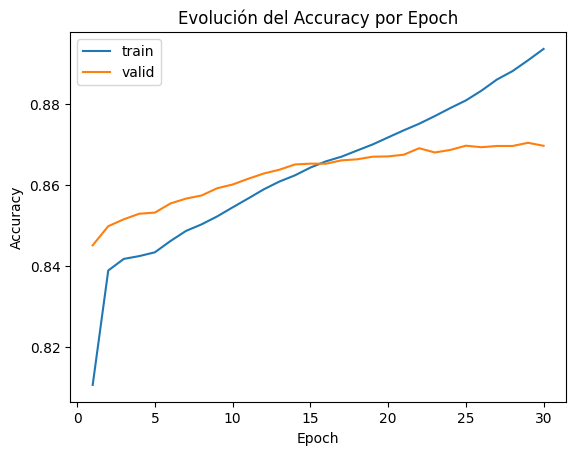

In [27]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy por Epoch")
plt.show()

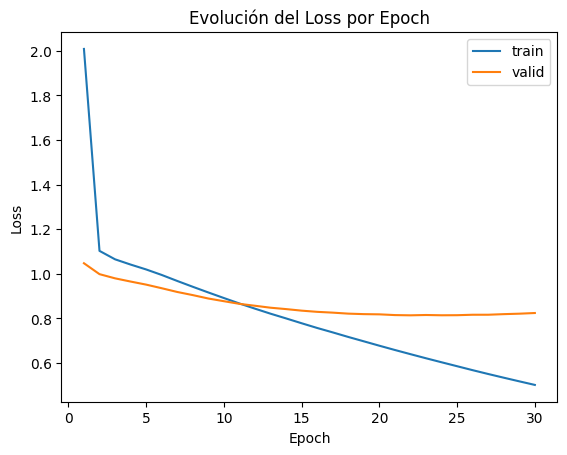

In [28]:
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución del Loss por Epoch")
plt.show()

### 6 - Inferencia

In [29]:
# Conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [48]:
input_inferences = []

for input in INPUT_TESTS:
  output = traducir(input=input, input_tokenizer=input_tokenizer, max_input_len=MAX_INPUT_LEN)
  input_inferences.append({"input": input, "output": output})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [49]:
for elem in input_inferences:
  print("="*50)
  print(f"Input: {elem["input"]}\nOutput: {elem["output"]}")

Input: My mother says hi.
Output: ella se dio el
Input: Mary wants to buy a dress.
Output: ella fue a su casa
Input: My mother takes a nap every afternoon.
Output: mi madre me ha perdido un gran suma
Input: My father is looking for you.
Output: mi padre es mi amigo
Input: You are the laziest student
Output: estás son el teléfono


#### ***Resultados de Traducciones***
Se observa que las traducciones (inferencias) obtenidas son erróneas, teniendo casos en donde algunas de éstas son frase incoherentes.

La frase `My mother says hi` fue traducida en una frase carente de sentido: `ella se dio el`.

La frase `Mary wants to buy a dress` fue traducida erróneamente en `ella fue a su casa`, pero el resultado si es coherente. El modelo traduce a `Mary` como `ella`, lo cual es erróneo en cuanto a traducción, pero correcto en la semántica.

La frase `My mother takes a nap every afternoon` se traduce erróneamente en `mi madre me ha perdido un gran suma`, pero el resultado si es coherente. El modelo traduce correctamente al sujeto de la frase: `My mother` como `Mi madre`.

La frase `My father is looking for you` (que **NO** es parte del dataset) se traduce erróneamente en `mi padre es mi amigo`, pero el resultado si es coherente. El modelo traduce correctamente el inicio de la frase: `My father` como `Mi padre`, pero confunde el resto. Un detalle a destacar es que traduce de manera literal el `is` como `es`, cuando debería ser `está` (`mi padre te está buscando`).

La frase `You are the laziest student` (que **NO** es parte del dataset) fue traducida en una frase carente de sentido: `estás son el teléfono`.

#### ***Conclusiones del experimento***

El traductor con $4000$ palabras de salida, sentencia de entrada más larga de $32$ palabras y sentencia de salida más larga de $36$ **NO** traduce de manera correcta a pesar de que se obtuvo un **accuracy** en **validation** de $0.8696$ en el último epoch ($30$).

Se observa igualmente que algunas traducciones son coherentes, es decir, el resultado es una oración *correcta*, pero una traducción **incorrecta**.

El motivo puede deberse a:

- Sobreentrenamiento: se observa que el **accuracy** de **validation** del modelo se estanca en el EPOCH $15$ (aproximadamente), mientras que en **train** sigue creciendo.
- Embeddings utilizados: por motivos de limitaciones de RAM, se utilizaron embeddings Glove de dimension 50.
- Palabras de salida igual a $4000$: también elegidas por limitaciones de RAM.
- Nueronas utilizadas en las capas LSTM ($128$).
- Largo máximo de sentencias de entrada y salida ($32$ y $36$ respectivamente).

## Experimento Número 2

En este experimento se explora la creación de un modelo traductor de inglés a español **seq2seq** utilizando una arquitectura **encoder-decoder**.

El mismo está basado en el **Experimento número 1**, por la misma configuración para los siguientes parámetros:

- **Vocabulario** de $4000$ palabras de salida a partir de un dataset dado (con $6000$ rows). Recordar que esto es por limitaciones de RAM.
- Tanto el **encoder** como el **decoder** utilizan celdas **LSTM**, las cuales presentan $128$ unidades de salida (neuronas).
- El **encoder** utiliza **embeddings** preentrenados del tipo Glove, con dimensión $50$.

A fin de mejorar los resultados, se proponen los siguientes cambios
- El modelo es entrenado durante $20$ epochs.
  - Recordar que en el **experimento 1** se entrenó durante $30$, notando un estancamiento del **accuracy** de validation alrededor del epoch $15$.
- Reducción a la mitad de los siguientes valores
  - Sentencia de entrada más larga: $16$.
  - Sentencia de salida más larga: $18$.

**NOTAS**

- Al entrenar el modelo definido con $4000$ palabras de salida (y el resto de los parámetros definidos) se utilizaron aproximadamente $7.7$ GB de RAM en Colab.

### 1 - Constantes del experimento

In [65]:
MAX_VOCAB_SIZE = 4000
N_UNITS = 128
EPOCHS = 20
MAX_INPUT_LEN = 16
MAX_OUTPUT_LEN = 18
model_embeddings = GloveEmbeddings()

### 2 - Preprocesamiento

- Palabras en el vocabulario: $3851$.
- Sentencia de entrada más larga: $16$.
- Palabras en el vocabulario: $5721$.
- Sentencia de salida más larga: $18$.
- Cantidad de rows del dataset: $6000$.
- Cantidad de palabras de salida: $4000$.
- encoder_input_sequences shape: $(6000, 16)$.
- decoder_input_sequences shape: $(6000, 18)$.


In [66]:
input_tokenizer, input_integer_seq, word2idx_inputs, output_tokenizer, output_integer_seq, output_input_integer_seq, word2idx_outputs, num_words_output = input_output_tokenizer(input_sentences=input_sentences, output_sentences=output_sentences, output_sentences_inputs=output_sentences_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [67]:
encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, decoder_targets = generar_encoder_decoder_sequences(input_integer_seq=input_integer_seq, output_integer_seq=output_integer_seq, output_input_integer_seq=output_input_integer_seq, num_words_output=num_words_output, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN)

In [78]:
print("Palabras en el vocabulario:", len(word2idx_inputs))
print("Palabras en el vocabulario:", len(word2idx_outputs))
print("Cantidad de rows del dataset:", len(input_integer_seq))
print("Cantidad de palabras de salida:", num_words_output)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Palabras en el vocabulario: 3851
Palabras en el vocabulario: 5721
Cantidad de rows del dataset: 6000
Cantidad de palabras de salida: 4000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)


### 3 - Preparar los embeddings

In [69]:
embedding_matrix, words_not_found, nb_words, embed_dim = crear_matriz_embeddings_para_inputs(model_embeddings=model_embeddings, word2idx_inputs=word2idx_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [70]:
print('Cantidad de embeddings con palabras nulas (null word embeddings):', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print('Dimensión de los embeddings de la secuencia en inglés:', embedding_matrix.shape)

Cantidad de embeddings con palabras nulas (null word embeddings): 30
Dimensión de los embeddings de la secuencia en inglés: (3851, 50)


### 4 - Entrenar el modelo

In [71]:
model, encoder_model, decoder_model = generar_modelos(n_units=N_UNITS, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN, num_words_output=num_words_output, embedding_matrix=embedding_matrix, nb_words=nb_words, embed_dim=embed_dim)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [72]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5993 - loss: 4.4863 - val_accuracy: 0.6979 - val_loss: 2.0415
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6822 - loss: 2.1651 - val_accuracy: 0.7014 - val_loss: 1.9800
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6869 - loss: 2.0884 - val_accuracy: 0.7056 - val_loss: 1.9453
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6852 - loss: 2.0728 - val_accuracy: 0.7057 - val_loss: 1.9054
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6921 - loss: 1.9848 - val_accuracy: 0.7096 - val_loss: 1.8694
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6952 - loss: 1.9400 - val_accuracy: 0.7121 - val_loss: 1.8364
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7029 - loss: 1.8630 - val_accuracy: 0.7164 - val_loss: 1.8050
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7049 - loss: 1.8211 - val_accu

### 5 - Gráficos

Se observa que el **accuracy** en **validation** es mayor que el **accuracy** en **train** hasta el epoch $15$ (aproximadamente), similar a como sucede en el **Experimento 1**.

En los epochs posteriores, el **accuracy** de train es mayor, lo cual podría indicar que estamos **sobreentrenando** el modelo.

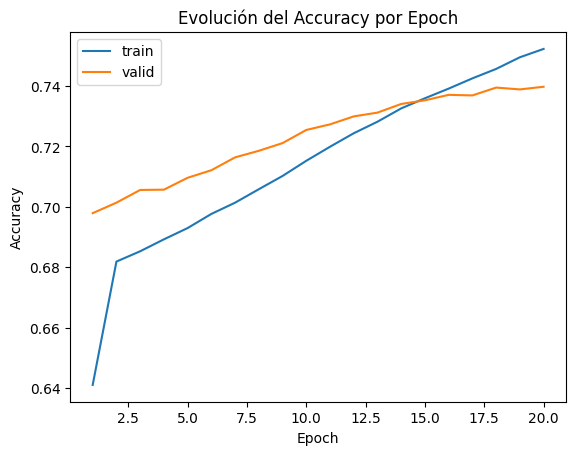

In [73]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy por Epoch")
plt.show()

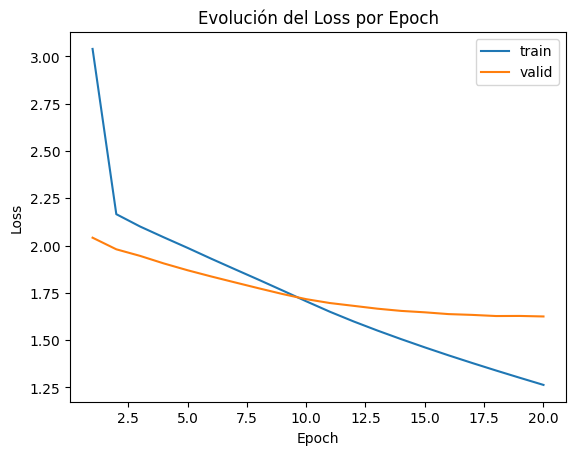

In [74]:
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución del Loss por Epoch")
plt.show()

### 6 - Inferencia

In [75]:
# Conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [76]:
input_inferences = []

for input in INPUT_TESTS:
  output = traducir(input=input, input_tokenizer=input_tokenizer, max_input_len=MAX_INPUT_LEN)
  input_inferences.append({"input": input, "output": output})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━

In [77]:
for elem in input_inferences:
  print("="*50)
  print(f"Input: {elem["input"]}\nOutput: {elem["output"]}")

Input: My mother says hi.
Output: mi madre
Input: Mary wants to buy a dress.
Output: mi madre se ha hecho con los
Input: My mother takes a nap every afternoon.
Output: mi madre se ha de una buena
Input: My father is looking for you.
Output: mi padre es mi padre
Input: You are the laziest student
Output: estás de mí


#### ***Resultados de Traducciones***
Se observa que las traducciones (inferencias) obtenidas son erróneas, teniendo casos en donde algunas de éstas son frase incoherentes.

La frase `My mother says hi` presenta una traducción incompleta: `mi madre`.

La frase `Mary wants to buy a dress` fue traducida erróneamente en `mi madre se ha hecho con los`.

La frase `My mother takes a nap every afternoon` fue traducida en una frase carente de sentido: `mi madre se ha de una buena`. Se observa que el modelo si traduce correctamente el inicio de la frase: `my mother` como `mi madre`.

La frase `My father is looking for you` (que **NO** es parte del dataset) se traduce erróneamente en `mi padre es mi padre`. El comienzo de la oración es traducido correctamente.

La frase `You are the laziest student` (que **NO** es parte del dataset) fue traducida en una frase carente de sentido: `estás de mí`.

#### ***Conclusiones del experimento***

El traductor con $4000$ palabras de salida, sentencia de entrada más larga de $16$ palabras y sentencia de salida más larga de $18$ **NO** traduce de manera correcta, a pesar de haber obtenido un *accuracy** en validation de $0.7398$ en el último epoch ($20$).

Se observa que en algunos casos las traducciones tienen el sujeto traducidos correctamente (como en la primer, tercer y cuarta frase), pero en general son incorrectos, contando también con traducciones incompletas (primer frase).

También se nota una baja en el **accuracy** del modelo al comparar con el **experimento 1**, la cual es de $0.8696$ a $0.7398$.

De manera similar al **experimento 1**, el **accuracy** en **validation** es mayor al **accuracy** de train hasta (aproximadamente) el epoch $15$. Luego, la situación se revierte, lo cual podría indicar que estamos haciendo **overfitting**.

El motivo puede deberse a:

- Sobreentrenamiento: se observa que el **accuracy** de **validation** del modelo se estanca en el EPOCH $15$ (aproximadamente), mientras que en **train** sigue creciendo.
- Embeddings utilizados: por motivos de limitaciones de RAM, se utilizaron embeddings Glove de dimension 50.
- Palabras de salida igual a $4000$: también elegidas por limitaciones de RAM.
- Nueronas utilizadas en las capas LSTM ($128$).
- Largo máximo de sentencias de entrada y salida ($16$ y $18$ respectivamente).

A partir de la comparación con el **Experimento 1** podemos decir que:
- La cantidad óptima de EPOCHs ronda a $15$.
- Los largos máximos de sentencias de entrada y salida de $16$ y $18$ son peores que los utilizados en el **Experimento 1** ($32$ y $36$ respectivamente).

Estos hallazgos nos permitirán definir mejor el siguiente experimento.